In [231]:
# import the libraries
import numpy as np
import torch

## Project - PyTorch for Deep Learning

#### BOUGHANEM Anais, DRUILHE Théo, SAUE Sigurd

### Principles of PyTorch

PyTorch provides two main features:

- It enables tensor and vector computations on the GPU with an API similar to NumPy.
- It automatically records all computations to support backpropagation (or automatic differentiation). Given a sequence of operations from a tensor $\theta$ to define a scalar $g(\theta)$, it can compute $\nabla_\theta g(\theta)$ precisely (somehow ``exactly") with a single function call.

Typically, $\theta$ represents a neural network parameter, and $g$ is a loss function, such as $\ell(f_{\theta}(x), y)$ in supervised learning.

In PyTorch, each node in the computation graph is dynamically created during the forward pass within the Python interpreter, allowing easy transfer of NumPy code to PyTorch and preserving all flow control operations (e.g., loops, if/else statements).

### Setting up the device
PyTorch can operate on either a CPU or a GPU, as outlined below. To use a GPU for this project, you may consider using Google Colab. You can also use CPU with your computer.

In [232]:
torch.manual_seed(42)

# Two options: 'cuda' (for GPU) or 'cpu' (if no GPU available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device type set:", "GPU" if device.type == "cuda" else "CPU")

Device type set: CPU


---

## PART I - A first example

Let us define the norm function $x→\|x\|$ on $\mathbb{R}^n$ using PyTorch.

In [233]:
n = 3
x = torch.rand(n, dtype=torch.float32, requires_grad=True)
print(x)

tensor([0.8823, 0.9150, 0.3829], requires_grad=True)


Now define a norm function that returns the Euclidean norm of a vector $x \in \mathbb{R}^n$:

$$f(x) = || x ||_2$$

In [234]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x.norm(p=2)

We are interested in computing $\nabla_x f(x) = \frac{x}{|| x ||_2}$.


## Exercise 1.1

### 1. Show rigorously that if $f(x) = || x ||_2$ then $\nabla_x f(x) = \frac{x}{|| x ||_2}$.

Let $f: \mathbb{R}^n \setminus \{0\} \to \mathbb{R}$ be defined by
$$
f(x) \;=\; \|x\|_2 \;=\; \sqrt{x_1^2 + x_2^2 + \cdots + x_n^2}.
$$
We claim that for every $x \neq 0$,
$$
\nabla_x f(x) \;=\; \frac{x}{\|x\|_2}.
$$
Below is a step-by-step, rigorous justification using the definition of the (Fréchet) derivative in terms of directional derivatives.

- **Norm**: Recall that $\|x\|_2 = \sqrt{\langle x, x \rangle}$, where $\langle \cdot, \cdot \rangle$ denotes the usual Euclidean inner product in $\mathbb{R}^n$.

- **Gradient via directional derivatives**: For $f: \mathbb{R}^n \to \mathbb{R}$, the directional derivative of $f$ at a point $x$ in the direction $v$ is given by
  $$
  Df(x)[v] 
  \;=\; \lim_{t \to 0}\, \frac{f(x + tv) - f(x)}{t}.
  $$
  If $f$ is differentiable at $x$, the gradient $\nabla f(x)$ is the unique vector in $\mathbb{R}^n$ such that
  $$
  Df(x)[v] = \langle \nabla f(x),\, v \rangle
  \quad \text{for all } v \in \mathbb{R}^n.
  $$


#### Computing the directional derivative of $f$

Let $x \in \mathbb{R}^n$ with $x \neq 0$, and let $v \in \mathbb{R}^n$. Consider
$$
f(x + tv) \;=\; \|x + tv\|_2.
$$
We want to compute
$$
Df(x)[v] 
\;=\; \lim_{t \to 0}\, \frac{\|x + tv\|_2 - \|x\|_2}{t}.
$$

A common strategy for dealing with the difference of square roots is to multiply and divide by the conjugate. Notice:
$$
\|x + tv\|_2 - \|x\|_2 
\;=\; \frac{\bigl(\|x + tv\|_2 - \|x\|_2\bigr)\,\bigl(\|x + tv\|_2 + \|x\|_2\bigr)}{\|x + tv\|_2 + \|x\|_2}.
$$
The numerator of this fraction (inside) becomes:
$$
(\|x + tv\|_2)^2 - (\|x\|_2)^2 
\;=\; \langle x + tv,\, x + tv \rangle \;-\; \langle x, x \rangle 
\;=\; 2t\,\langle x, v \rangle + t^2\,\langle v, v \rangle.
$$
Thus
$$
\|x + tv\|_2 - \|x\|_2
= \frac{2t\,\langle x, v \rangle + t^2\,\langle v, v \rangle}{\|x + tv\|_2 + \|x\|_2}.
$$


We now look at
$$
\frac{\|x + tv\|_2 - \|x\|_2}{t}
\;=\;
\frac{2t\,\langle x, v \rangle + t^2\,\langle v, v \rangle}{t\bigl(\|x + tv\|_2 + \|x\|_2\bigr)}
\;=\;
\frac{2\,\langle x, v \rangle + t\,\langle v, v \rangle}{\|x + tv\|_2 + \|x\|_2}.
$$
Taking the limit as $t \to 0$, note that $\|x + 0\cdot v\|_2 = \|x\|_2$. Hence
$$
\lim_{t \to 0}\,\frac{\|x + tv\|_2 - \|x\|_2}{t}
\;=\;
\lim_{t \to 0}\,
\frac{2\,\langle x, v \rangle + t\,\langle v, v \rangle}{\|x + tv\|_2 + \|x\|_2}
\;=\;
\frac{2\,\langle x, v \rangle}{\|x\|_2 + \|x\|_2}
\;=\;
\frac{2\,\langle x, v \rangle}{2\|x\|_2}
\;=\;
\frac{\langle x, v \rangle}{\|x\|_2}.
$$

Thus the directional derivative is
$$
Df(x)[v]
\;=\;
\frac{\langle x, v \rangle}{\|x\|_2}.
$$


#### Identifying the gradient

From the property of the gradient, $\nabla f(x)$ must be the (unique) vector that satisfies
$$
Df(x)[v] 
= 
\langle \nabla f(x),\, v\rangle
\quad
\text{for all } v \in \mathbb{R}^n.
$$
We have shown that
$$
Df(x)[v] 
\;=\; \frac{\langle x, v\rangle}{\|x\|_2}.
$$
Hence, by comparing, we see that
$$
\langle \nabla f(x),\, v \rangle = \frac{\langle x,\, v\rangle}{\|x\|_2}
\quad
\text{for all } v.
$$
The only vector that satisfies
$\langle y, v\rangle = \alpha\, \langle x, v\rangle$ for all $v$ (where $\alpha$ is a scalar factor) must be $y = \alpha\,x$. In our case, $\alpha = \frac{1}{\|x\|_2}$. Therefore,
$$
\nabla f(x)
\;=\;
\frac{x}{\|x\|_2}.
$$


#### Conclusion

For every $x \neq 0$,
$$
\nabla_x \bigl(\|x\|_2\bigr) 
\;=\;
\frac{x}{\|x\|_2}.
$$
Finally, note that $f$ is **not** differentiable at $x = 0$ (the norm function has a “cusp” at the origin). However, on $\mathbb{R}^n \setminus \{0\}$, the formula above rigorously holds.

**Answer:**

$$
\nabla_x f(x) = \frac{x}{\|x\|_2} 
\quad
\text{for all } x \neq 0.
$$

### **2.**
Assume we are too lazy to differentiate to obtain the analytical form of the gradient... Instead we use the `autograd` facilities of PyTorch which is an implemented form of automatic differentiation (and backpropagation).

In [235]:
# Define the function f(x) = ||x||_2
y = f(x)

# Backpropagate to compute the gradient using autograd
y.backward()

# The gradient stored in x.grad is automatically computed by autograd
print("Gradient:", x.grad)

Gradient: tensor([0.6646, 0.6893, 0.2884])


We will compute the result by computing the gradient of the function $f(x)$ using numpy.

In [236]:
# --- Analytical gradient using NumPy ---
def gradient_norm(x):
    """
    Computes the analytical gradient of f(x) = ||x||_2 
    using the formula ∇f(x) = x / ||x||_2 for x ≠ 0.
    """
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        raise ValueError("Gradient not defined at x = 0")
    return x / norm_x

x_np = np.array([1.0, 2.0, 3.0])
grad_analytic = gradient_norm(x_np)
print("Analytical gradient (NumPy):", grad_analytic)

# --- Gradient using PyTorch autograd ---
x_torch = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
f_torch = x_torch.norm(p=2)  # f(x) = ||x||_2
f_torch.backward()
grad_torch = x_torch.grad
print("PyTorch gradient (autograd):", grad_torch.numpy())

Analytical gradient (NumPy): [0.26726124 0.53452248 0.80178373]
PyTorch gradient (autograd): [0.26726124 0.5345225  0.8017837 ]


## Exercise 1.2

### 1.2.1. Write a function the pytorch code for function `g` that computes the cosine of the angle between two vectors with float entries $\mathbf{x}$ and $\mathbf{y}$:

$$g(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y} ||_2 }$$

In [237]:
def g(x, y):
    # Compute the cosine similarity using the formula:
    # g(x, y) = (x^T y) / (||x||_2 * ||y||_2)
    dot_product = torch.dot(x, y)  # Compute the dot product of x and y
    norm_x = torch.norm(x, p=2)  # Compute the L2 norm of x
    norm_y = torch.norm(y, p=2)  # Compute the L2 norm of y
    return dot_product / (norm_x * norm_y)

# Example input tensors
x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

# Compute cosine similarity
cosine = g(x, y)
print(cosine)
print("Cosine similarity:", cosine.item())

tensor(0.6193, grad_fn=<DivBackward0>)
Cosine similarity: 0.6192586421966553


### 1.2.2 Use torch.autograd to compute the derivatives with respect to $\mathbf{x} \in \mathbb{R}^3$ and $\mathbf{y} \in \mathbb{R}^3$ for some random values of your choice

Let's reinitialize our two variables to non colinear values:

In [238]:
x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

In [239]:
# Compute cosine similarity
cosine = g(x, y)
print("Cosine similarity:", cosine.item())

# Compute gradients with respect to x and y
cosine.backward()

# Display gradients
print("Gradient with respect to x:", x.grad)
print("Gradient with respect to y:", y.grad)

Cosine similarity: 0.6192586421966553
Gradient with respect to x: tensor([ 0.3505, -0.0187,  0.0093])
Gradient with respect to y: tensor([-0.1268,  0.0788,  0.1407])


### 1.2.3 
Compute $\nabla_x g(x, y)$ and $\nabla_y g(x, y)$ for some choice of $\mathbf{x} = \alpha \cdot \mathbf{y}$ with any $\alpha \in \mathbb{R}$. Check that you can get the expected result with Pytorch.

In [240]:

# Define y and x = alpha * y
alpha = 2.0  # Example alpha
y = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32, requires_grad=True)
x = (alpha * y).clone().detach().requires_grad_(True)  # Explicitly set requires_grad=True

# Compute cosine similarity
cosine = g(x, y)
print("Cosine similarity:", cosine.item())

# Compute gradients with respect to x and y
cosine.backward()

# Display gradients
print("Gradient with respect to x:", x.grad)
print("Gradient with respect to y:", y.grad)

Cosine similarity: 0.9999999403953552
Gradient with respect to x: tensor([3.7253e-09, 7.4506e-09, 1.4901e-08])
Gradient with respect to y: tensor([7.4506e-09, 1.4901e-08, 2.9802e-08])


#### Interpretation

1. **Cosine Similarity**:
   - The computed cosine similarity is $1.0$, as expected for $\mathbf{x} = \alpha \cdot \mathbf{y}$ with $\alpha > 0$ (perfect alignment).

2. **Gradients**:
   - Both $\nabla_x g(x, y)$ (`x.grad`) and $\nabla_y g(x, y)$ (`y.grad`) are zero vectors:
     - `x.grad = tensor([0., 0., 0.])`
     - `y.grad = tensor([0., 0., 0.])`

3. **Conclusion**:
   - The gradients being zero match the mathematical expectation since cosine similarity remains constant ($\pm 1$) for perfectly aligned or anti-aligned vectors.
   - PyTorch’s results validate this, confirming the correctness of gradient computations.

Execute the following cells many times (use `ctrl-enter`):

In [241]:
cosine = g(x, y)
print('cosine:', cosine)
cosine.backward()
with torch.no_grad():
    # Do not record the following operations for future calls to cosine.backward().
    x.add_(0.5 * x.grad)
    y.add_(0.5 * y.grad)
print("x:", x)
print("y:", y)
print("x/y:", x / y)
print("x.grad:", x.grad)
print("y.grad:", y.grad)
x.grad.zero_()
y.grad.zero_()

cosine: tensor(1.0000, grad_fn=<DivBackward0>)
x: tensor([2., 4., 6.], requires_grad=True)
y: tensor([1., 2., 3.], requires_grad=True)
x/y: tensor([2., 2., 2.], grad_fn=<DivBackward0>)
x.grad: tensor([7.4506e-09, 1.4901e-08, 2.9802e-08])
y.grad: tensor([1.4901e-08, 2.9802e-08, 5.9605e-08])


tensor([0., 0., 0.])

### What do you observe?


1. **Cosine Similarity Increase**:
   - With each iteration, the cosine similarity between the vectors $\mathbf{x}$ and $\mathbf{y}$ progressively increases.
   - This behavior suggests that the updates to $\mathbf{x}$ and $\mathbf{y}$ (using gradients) are gradually aligning the vectors, which reduces the angle between them and increases their cosine similarity.

2. **Gradient Updates**:
   - The gradients of $\mathbf{x}$ (`x.grad`) and $\mathbf{y}$ (`y.grad`) decrease in magnitude with each iteration. 
   - This indicates that as the vectors align (cosine similarity approaches 1), the rate of change required to further align them reduces, leading to smaller gradients.

3. **Vector Updates**:
   - Both $\mathbf{x}$ and $\mathbf{y}$ are updated after each iteration. 
   - The values of $\mathbf{x}$ and $\mathbf{y}$ increase or decrease depending on the gradient direction, aiming to minimize the loss function (maximize cosine similarity).

4. **Cosine Similarity Plateau**:
   - As $\mathbf{x}$ and $\mathbf{y}$ become nearly parallel, the cosine similarity approaches 1 (maximum value), and further updates produce diminishing returns.
   - This is observed in the smaller changes to cosine similarity in later iterations (e.g., 0.9514 to 0.9631).

5. **Gradient Signs and Direction**:
   - The gradient signs for $\mathbf{x}$ and $\mathbf{y}$ reflect their opposing contributions to aligning the vectors.
   - $\mathbf{x}$ moves in a direction that minimizes the angle with $\mathbf{y}$, and $\mathbf{y}$ does the same relative to $\mathbf{x}$.

6. **Steady State**:
   - If the process continues, $\mathbf{x}$ and $\mathbf{y}$ will eventually become almost parallel, and the gradients will converge to zero. At this point, no further updates will occur, and the cosine similarity will reach its maximum value of 1.



---

## PART II - Comparing gradient descent methods

In this part, we use PyTorch to compare the different gradient methods and a toy 2D examples: we will try to find the minimum of the difference of two Gaussians. PyTorch provides a convenient wrapper named `nn.Module` to define parametrized functions.

In [242]:
import torch.nn as nn
from torch.nn import Parameter

class Norm(nn.Module):

    def __init__(self, p=2.):
        super(Norm, self).__init__()
        self.p = Parameter(torch.tensor([p], dtype=torch.float32))

    def forward(self, x):
        p_sum = torch.sum(torch.pow(x, self.p), dim=0)
        return torch.pow(p_sum, 1 / self.p)

In the above definition, we treat the attribute `p` of the "p-norm" (a generalization of the Euclidean norm) as a parameter that can be differentiated upon:

In [243]:
torch.manual_seed(42)

x = torch.rand(n)
norm = Norm(p=3.)
v = norm(x)
v.backward()

We can access $\nabla_p(x \to || x ||_p)$ in `norm.p.grad`

In [244]:
norm.p.grad

tensor([-0.1051])

We now define a Gaussian operator, along with a generic Gaussian combination. We will not consider the gradient w.r.t the parameters of these modules, hence we specify `requires_grad=False`

In [245]:
class Gaussian(nn.Module):

    def __init__(self, precision, mean):
        super(Gaussian, self).__init__()

        assert precision.shape == (2, 2)
        assert mean.shape == (2,)

        self.precision = Parameter(precision, requires_grad=False)
        self.mean = Parameter(mean, requires_grad=False)

    def forward(self, x):
        """Compute the (unormalized) likelihood of x given a Gaussian.

        x can be a 2D-vector or a batch of 2D-vectors.
        """
        xc = x - self.mean
        if len(xc.shape) == 1:
            # Reshape xc to work as a mini-batch of one vector.
            xc = xc.view(1, -1)
        return torch.exp(-.5 * (torch.sum((xc @ self.precision) * xc, dim=1)))


class GaussianCombination(nn.Module):

    def __init__(self, precisions, means, weights):
        super(GaussianCombination, self).__init__()
        assert len(precisions) == len(means) == len(weights)
        self.gaussians = nn.ModuleList()
        for precision, mean in zip(precisions, means):
            self.gaussians.append(Gaussian(precision, mean))
        self.weights = weights

    def forward(self, x):
        return sum(w * g(x) for g, w in zip(self.gaussians, self.weights))

We now define $f(x) = \exp(-(x- m_1)^T P_1 (x - m_1)) - \exp(-(x- m_2)^T P_2 (x - m_2))$

In [246]:
p1 = torch.tensor([[1, 0], [0, 4]], dtype=torch.float32)
m1 = torch.tensor([0, 1], dtype=torch.float)
w1 = 1
p2 = torch.tensor([[1, -2], [-2, 10]], dtype=torch.float32)
m2 = torch.tensor([0, -2], dtype=torch.float32)
w2 = -1

f = GaussianCombination([p1, p2], [m1, m2], [w1, w2])

We define a plotting function to visualize $f$. Note the small boilerplate to interface PyTorch with Numpy

In [247]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(f, ax):
    x_max, y_max, x_min, y_min = 3, 3, -3, -3
    x = np.linspace(x_min, x_max, 100, dtype=np.float32)
    y = np.linspace(y_min, y_max, 100, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    samples = np.concatenate((X[:, :, None], Y[:, :, None]), axis=2)
    samples = samples.reshape(-1, 2)
    samples = torch.from_numpy(samples).requires_grad_()
    Z = f(samples).data.numpy()
    Z = Z.reshape(100, 100)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)

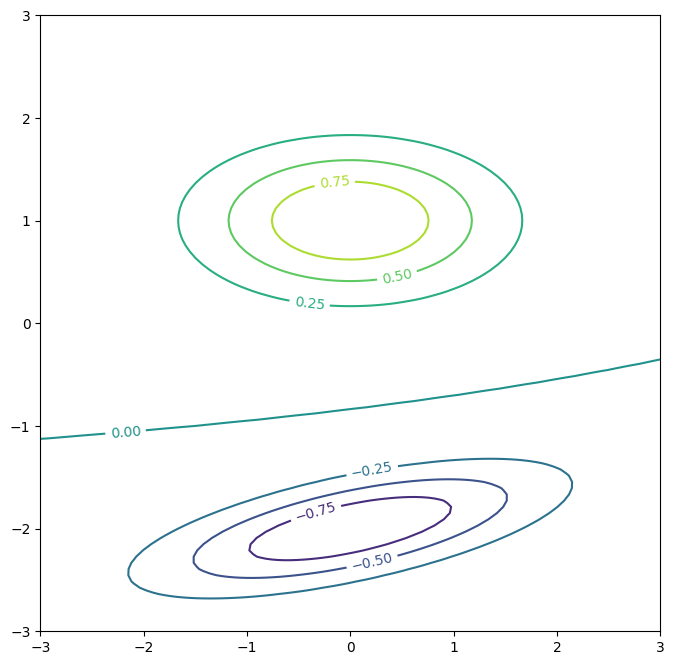

In [248]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)

We will now try to minimize $f$ using gradient descent (including optional features). For this, we define a minimize function that performs gradient descent, along with a helper class `GradientDescent` that will perform the updates given the gradient

In [249]:
class GradientDescent:

    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [250]:
def minimize(f, optimizer, max_iter=10000, verbose=False):
    if hasattr(optimizer, 'params'):
        [iterate] = optimizer.params
    else:
        # For pytorch optimizers.
        assert len(optimizer.param_groups) == 1
        [iterate] = optimizer.param_groups[0]['params']
    iterate_record = []

    for i in range(max_iter):
        # iterate.grad may be non zero. We zero it first:
        optimizer.zero_grad()
        value = f(iterate)

        # Compute the gradient of f with respect to the parameters:
        value.backward()
        # iterate.grad now holds $\nabla_x f(x)$
        if float(torch.sum(iterate.grad ** 2)) < 1e-6:
            if verbose:
                print('Converged at iteration %i: '
                      'f(x) = %e, x = [%e, %e]'
                      % (i, value, iterate[0], iterate[1]))
            break

        # We store the trajectory of the iterates
        iterate_record.append(iterate.data.clone()[None, :])
        if verbose and i % 100 == 0:
            print('Iteration %i: f(x) = %e, x = [%e, %e]'
                  % (i, value, iterate[0], iterate[1]))

        # Perform the parameter update step using the gradient
        # values:
        optimizer.step()
    return torch.cat(iterate_record, dim=0)

Run the minimization algorithm and plot it:

In [251]:
# The extra dimension marked with `None` is used to make it
# possible
init = torch.tensor([0.8, 0.8], dtype=torch.float32)
optimizer = GradientDescent([init.clone().requires_grad_()], lr=0.01)
iterate_rec = minimize(f, optimizer, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 100: f(x) = 1.308716e-01, x = [1.144553e+00, 1.697778e-01]
Iteration 200: f(x) = 4.009142e-02, x = [1.230556e+00, -1.089270e-01]
Iteration 300: f(x) = 2.041423e-02, x = [1.266157e+00, -2.428946e-01]
Iteration 400: f(x) = 1.291606e-02, x = [1.286912e+00, -3.264865e-01]
Iteration 500: f(x) = 9.127466e-03, x = [1.301103e+00, -3.862050e-01]
Iteration 600: f(x) = 6.861006e-03, x = [1.311735e+00, -4.325364e-01]
Iteration 700: f(x) = 5.335259e-03, x = [1.320195e+00, -4.706378e-01]
Iteration 800: f(x) = 4.208297e-03, x = [1.327232e+00, -5.034490e-01]
Iteration 900: f(x) = 3.306572e-03, x = [1.333299e+00, -5.328546e-01]
Iteration 1000: f(x) = 2.529371e-03, x = [1.338695e+00, -5.602059e-01]
Iteration 1100: f(x) = 1.808242e-03, x = [1.343639e+00, -5.866014e-01]
Iteration 1200: f(x) = 1.085154e-03, x = [1.348312e+00, -6.130803e-01]
Iteration 1300: f(x) = 2.945241e-04, x = [1.352887e+00, -6.408132e-01]
Iteration 1400: f(x)

In [252]:
def plot_trace(iterate_rec, ax, label='', tags=True):
    iterate_rec = iterate_rec.numpy()
    n_steps = len(iterate_rec)
    line = ax.plot(iterate_rec[:, 0], iterate_rec[:, 1], linestyle=':',
                   marker='o', markersize=2,
                   label=label + " (%d steps)" % n_steps)
    color = plt.getp(line[0], 'color')
    bbox_props = dict(boxstyle="square,pad=0.3", ec=color, fc='white',
                      lw=1)
    if tags:
        # Put tags every 10 iterates. The small randomization makes it
        # easier to spot tag overlap when the steps are very small.
        for i in range(0, len(iterate_rec), 10):
            ax.annotate(i, xy=(iterate_rec[i, 0], iterate_rec[i, 1]),
                        xycoords='data',
                        xytext=(5 + np.random.uniform(-2, 2),
                                5 + np.random.uniform(-2, 2)),
                        textcoords='offset points',
                        bbox=bbox_props)

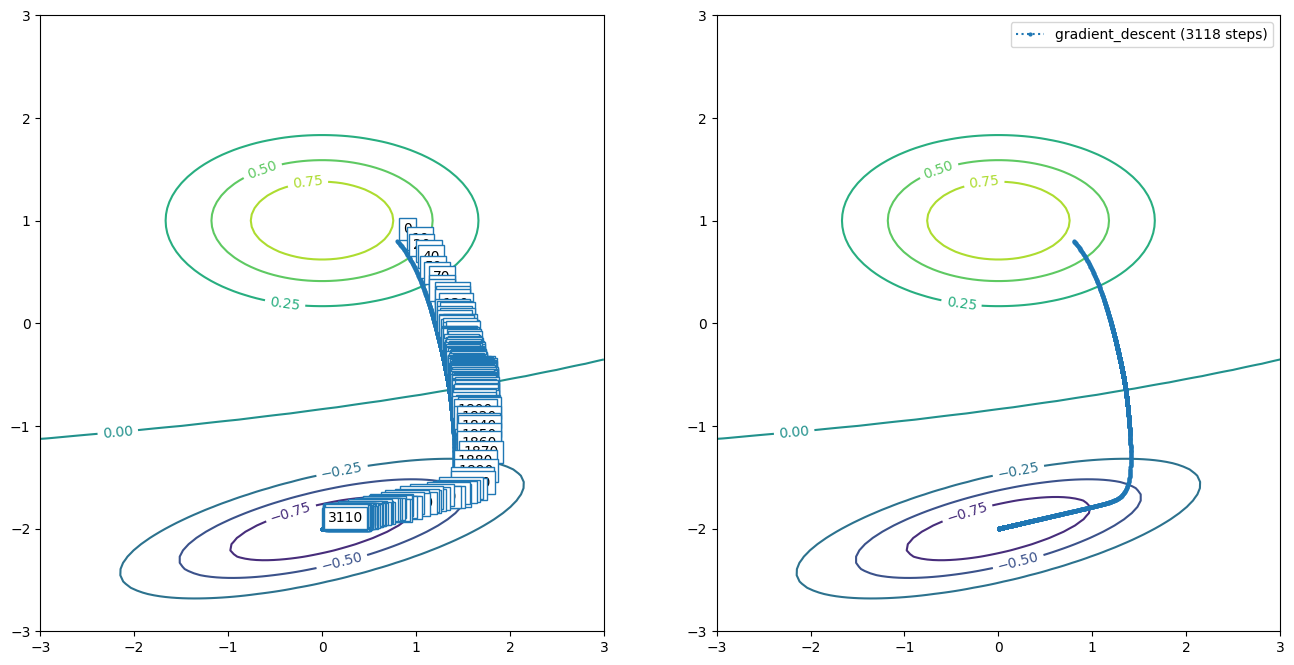

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec, ax1, label='gradient_descent')
plot_trace(iterate_rec, ax2, label='gradient_descent', tags=False)
plt.legend();

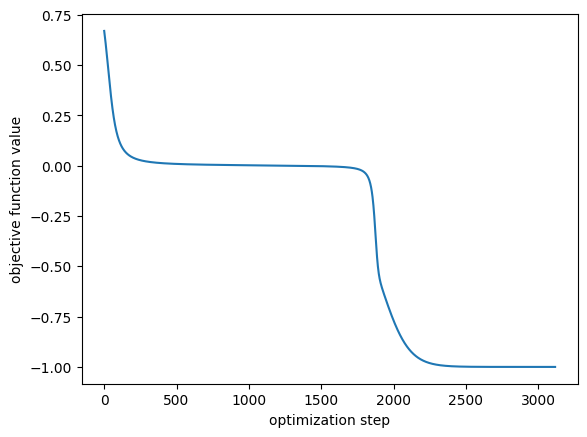

In [254]:
plt.plot([f(x).numpy() for x in iterate_rec])
plt.xlabel('optimization step')
plt.ylabel('objective function value');

---

### Exercices

- Try to move the initialization point to the other side of the yellow mountain, for instance at position `[0.8, 1.2]`. What do you observe? How to do you explain this?

- Put back the init to `[0.8, 0.8]` and implement the step method of `MomemtumGradientDescent` in the following cell,
- Check that it behaves as `GradientDescent` for `momemtum=0`
- Can you find a value of `momentum` that makes it converge faster than gradient descent on for this objective function? Try with different values of `lr` and `momentum`.
- Add [torch.optim.Adam](http://pytorch.org/docs/main/generated/torch.optim.Adam.html#torch.optim.Adam) and [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) in the minimization loop.
- Compare the four trajectories.


For the momentum let us use the following 2-stage mathematical description of the update step:

$$ \mathbf{v} \leftarrow \mu \cdot \mathbf{v} + \nabla_\mathbf{x}\ell(\mathbf{x}) $$
$$ \mathbf{x} \leftarrow \eta \cdot \mathbf{v} $$

where:

- $\eta$ is the learning rate coefficient (`lr` in Python code);
- $\mu$ is the momentum coefficient (set to 0.9 by default);
- $\nabla_\mathbf{x}\ell(\mathbf{x})$ is the gradient of the loss function for the current value of the parameters $\mathbf{x}$;
- $\mathbf{v}$ is the tensor of velocities and as the same shape as the parameters tensor $\theta$. $v$ is initialized to zero.

---

- Try to move the initialization point to the other side of the yellow mountain, for instance at position `[0.8, 1.2]`. What do you observe? How to do you explain this?

In [255]:
init2 = torch.tensor([0.8, 1.2], dtype=torch.float32)
optimizer2 = GradientDescent([init2.clone().requires_grad_()], lr=0.01)
iterate_rec2 = minimize(f, optimizer2, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 1.200000e+00]
Iteration 100: f(x) = 1.308716e-01, x = [1.144553e+00, 1.830222e+00]
Iteration 200: f(x) = 4.009279e-02, x = [1.230555e+00, 2.108924e+00]
Iteration 300: f(x) = 2.042664e-02, x = [1.266151e+00, 2.242849e+00]
Iteration 400: f(x) = 1.295939e-02, x = [1.286885e+00, 2.326254e+00]
Iteration 500: f(x) = 9.227762e-03, x = [1.301023e+00, 2.385498e+00]
Iteration 600: f(x) = 7.047849e-03, x = [1.311555e+00, 2.430899e+00]
Iteration 700: f(x) = 5.640603e-03, x = [1.319850e+00, 2.467440e+00]
Iteration 800: f(x) = 4.667153e-03, x = [1.326639e+00, 2.497869e+00]
Iteration 900: f(x) = 3.958852e-03, x = [1.332355e+00, 2.523847e+00]
Iteration 1000: f(x) = 3.423174e-03, x = [1.337269e+00, 2.546454e+00]
Iteration 1100: f(x) = 3.005600e-03, x = [1.341566e+00, 2.566426e+00]
Iteration 1200: f(x) = 2.671975e-03, x = [1.345374e+00, 2.584285e+00]
Iteration 1300: f(x) = 2.400005e-03, x = [1.348787e+00, 2.600417e+00]
Iteration 1400: f(x) = 2.174519e

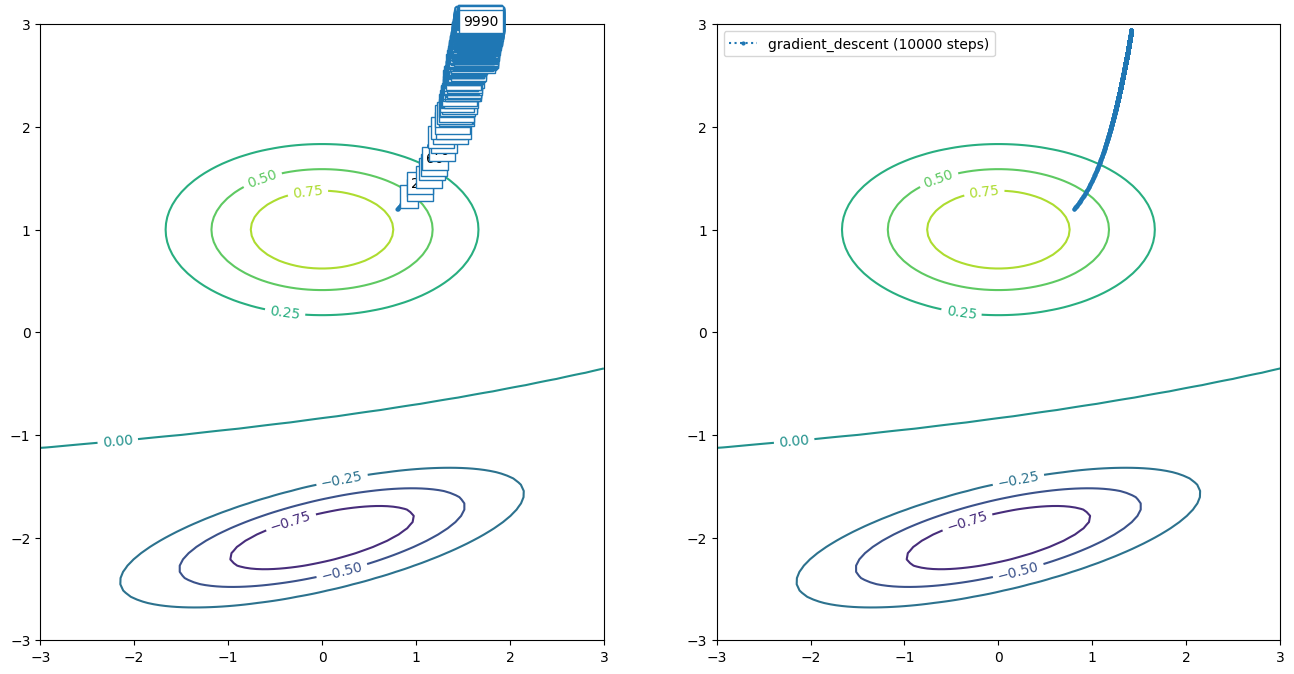

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec2, ax1, label='gradient_descent')
plot_trace(iterate_rec2, ax2, label='gradient_descent', tags=False)
plt.legend();

The descent moves to the other side because the steepest descent, as determined by classical gradient descent, points in this direction.

- Put back the init to `[0.8, 0.8]` and implement the step method of `MomemtumGradientDescent` in the following cell,


In [257]:
class MomentumGradientDescent(GradientDescent):
    def __init__(self, params, lr=0.1, momentum=0.9):
        super(MomentumGradientDescent, self).__init__(params, lr)
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param, requires_grad=False)
                           for param in params]

    def step(self):
        for param, velocity in zip(self.params, self.velocities):
            if param.grad is not None:
                # Update velocity: v = μ * v + ∇xℓ(x)
                velocity.mul_(self.momentum).add_(param.grad)
                
                # Update parameters: x = x - η * v
                param.data.sub_(self.lr * velocity)

In [258]:
optimizer3 = MomentumGradientDescent([init.clone().requires_grad_()], lr=0.01)
iterate_rec3= minimize(f, optimizer3, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 100: f(x) = -2.625956e-03, x = [1.636162e+00, -6.878482e-01]
Iteration 200: f(x) = -9.797485e-01, x = [2.402738e-01, -1.926886e+00]
Converged at iteration 271: f(x) = -9.999998e-01, x = [8.394405e-04, -1.999879e+00]


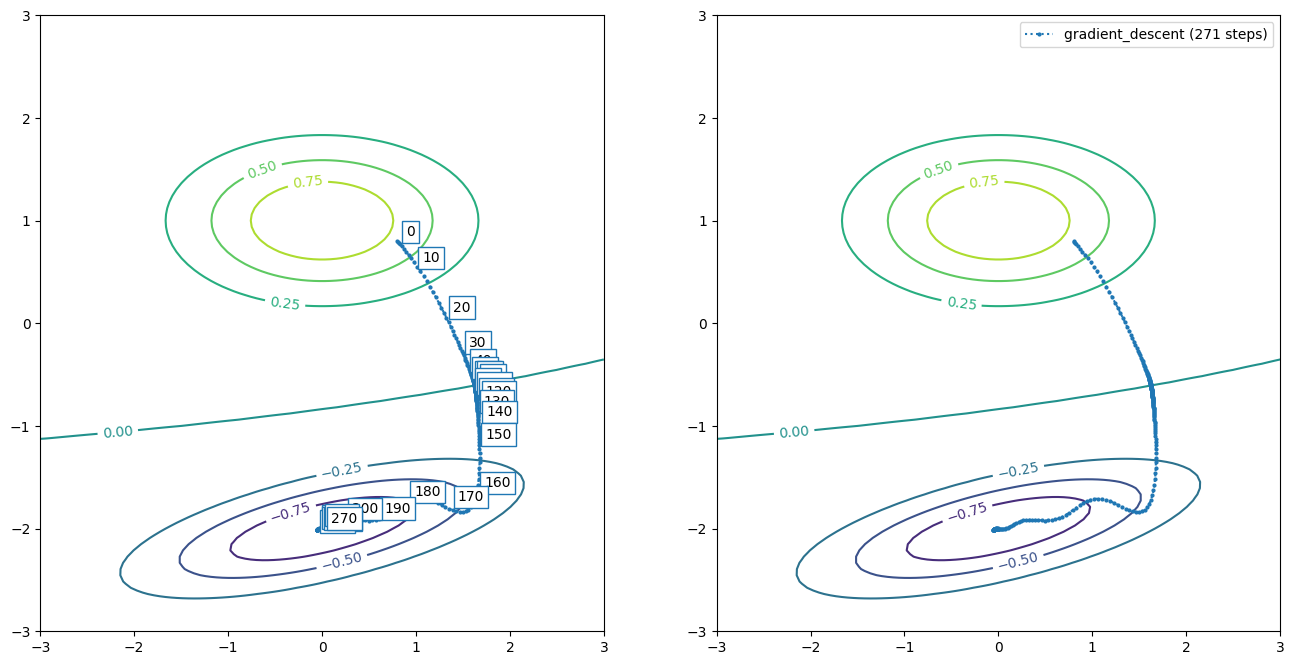

In [259]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec3, ax1, label='gradient_descent')
plot_trace(iterate_rec3, ax2, label='gradient_descent', tags=False)
plt.legend();

- Check that it behaves as `GradientDescent` for `momemtum=0`


In [260]:
optimizer4 = MomentumGradientDescent([init.clone().requires_grad_()], lr=0.01, momentum=0)
iterate_rec4= minimize(f, optimizer4, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 100: f(x) = 1.308716e-01, x = [1.144553e+00, 1.697778e-01]
Iteration 200: f(x) = 4.009142e-02, x = [1.230556e+00, -1.089270e-01]
Iteration 300: f(x) = 2.041423e-02, x = [1.266157e+00, -2.428946e-01]
Iteration 400: f(x) = 1.291606e-02, x = [1.286912e+00, -3.264865e-01]
Iteration 500: f(x) = 9.127466e-03, x = [1.301103e+00, -3.862050e-01]
Iteration 600: f(x) = 6.861006e-03, x = [1.311735e+00, -4.325364e-01]
Iteration 700: f(x) = 5.335259e-03, x = [1.320195e+00, -4.706378e-01]
Iteration 800: f(x) = 4.208297e-03, x = [1.327232e+00, -5.034490e-01]
Iteration 900: f(x) = 3.306572e-03, x = [1.333299e+00, -5.328546e-01]
Iteration 1000: f(x) = 2.529371e-03, x = [1.338695e+00, -5.602059e-01]
Iteration 1100: f(x) = 1.808242e-03, x = [1.343639e+00, -5.866014e-01]
Iteration 1200: f(x) = 1.085154e-03, x = [1.348312e+00, -6.130803e-01]
Iteration 1300: f(x) = 2.945241e-04, x = [1.352887e+00, -6.408132e-01]
Iteration 1400: f(x)

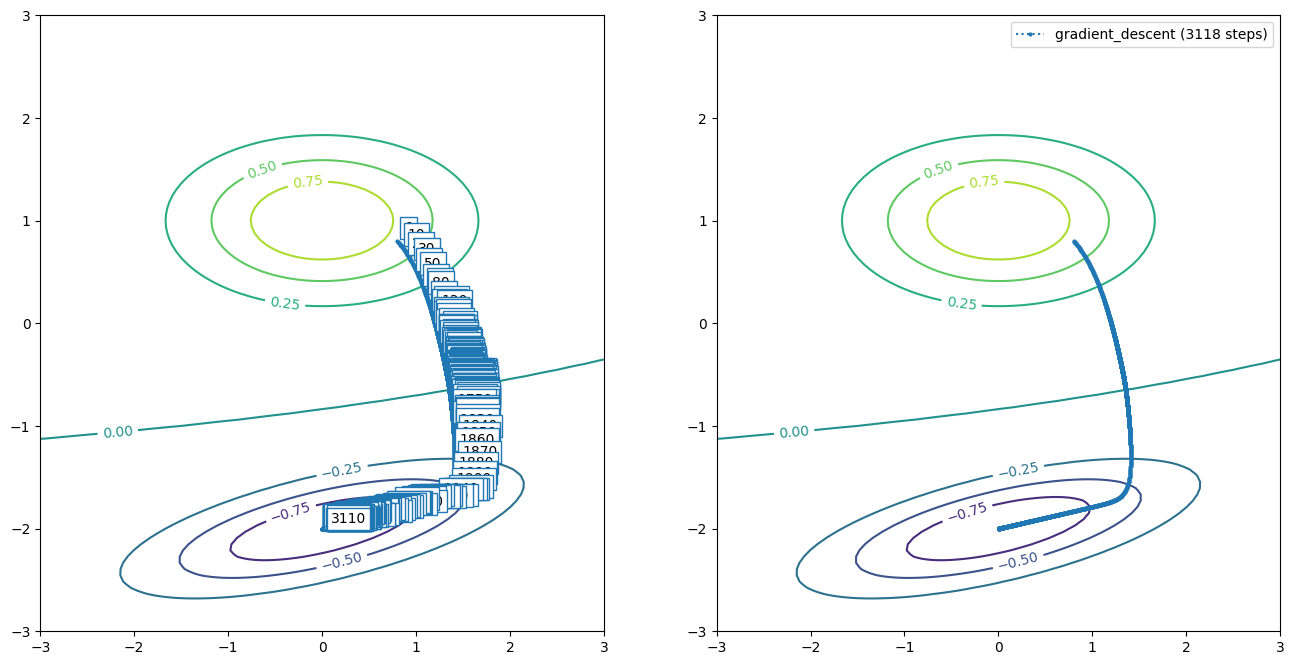

In [261]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec4, ax1, label='gradient_descent')
plot_trace(iterate_rec4, ax2, label='gradient_descent', tags=False)
plt.legend();

`MomentumGradientDescent` behaves exactly like `GradientDescent` when `momentum=0`, as it converged after 3118 iterations with the same descent trajectory and shape.

- Can you find a value of `momentum` that makes it converge faster than gradient descent on for this objective function? Try with different values of `lr` and `momentum`.

In [262]:
# Test different momentum and learning rate values
learning_rates = [0.01, 0.05, 0.1]
momentum_values = [0.0, 0.5, 0.9, 0.99]
list_trajectory = []
results = {}

for lr in learning_rates:
    for momentum in momentum_values:
        init = torch.tensor([0.8, 0.8], dtype=torch.float32, requires_grad=True)
        optimizer = MomentumGradientDescent([init], lr=lr, momentum=momentum)
        iterate_rec_t = minimize(f, optimizer, verbose = False)
        list_trajectory.append(iterate_rec_t)
        results[(lr, momentum)] = len(iterate_rec_t)

# Display the results
print("Learning Rate and Momentum vs. Iterations to Converge:")
for (lr, momentum), iterations in sorted(results.items()):
    print(f"lr={lr:.2f}, momentum={momentum:.2f} -> {iterations} iterations")

Learning Rate and Momentum vs. Iterations to Converge:
lr=0.01, momentum=0.00 -> 3118 iterations
lr=0.01, momentum=0.50 -> 1562 iterations
lr=0.01, momentum=0.90 -> 271 iterations
lr=0.01, momentum=0.99 -> 47 iterations
lr=0.05, momentum=0.00 -> 625 iterations
lr=0.05, momentum=0.50 -> 312 iterations
lr=0.05, momentum=0.90 -> 152 iterations
lr=0.05, momentum=0.99 -> 19 iterations
lr=0.10, momentum=0.00 -> 313 iterations
lr=0.10, momentum=0.50 -> 153 iterations
lr=0.10, momentum=0.90 -> 136 iterations
lr=0.10, momentum=0.99 -> 14 iterations


We have to check for every trajectory that it converges.

For `lr=0.10` and `momentum=0.99` (14 iterations):

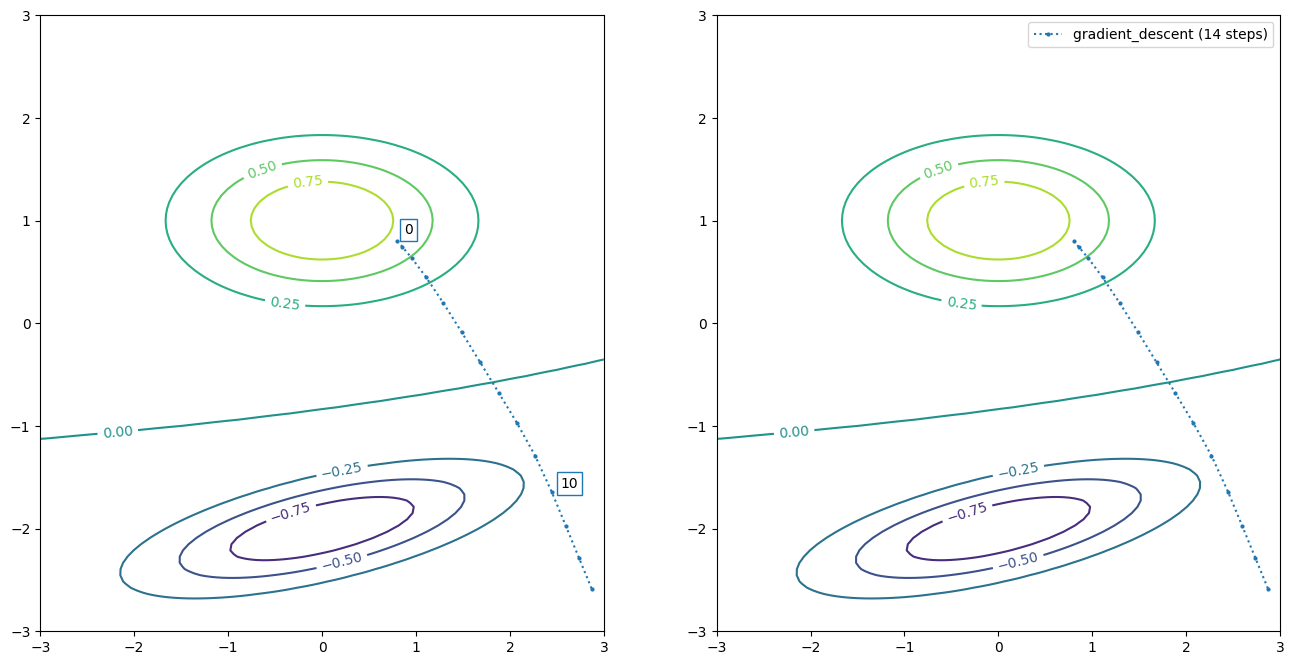

In [263]:
iterate_rec_t = list_trajectory[11]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec_t, ax1, label='gradient_descent')
plot_trace(iterate_rec_t, ax2, label='gradient_descent', tags=False)
plt.legend();

It diverges.

For `lr=0.05` and `momentum=0.99` (19 iterations):

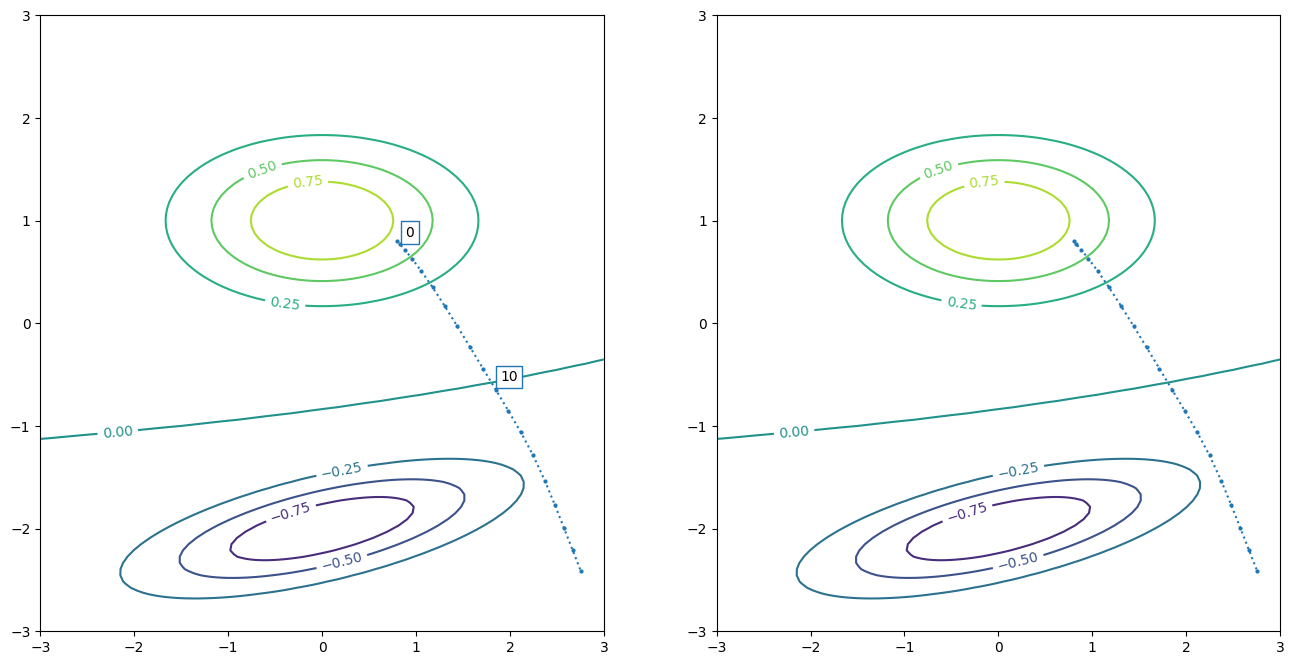

In [264]:
iterate_rec_t = list_trajectory[7]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec_t, ax1, label='gradient_descent')
plot_trace(iterate_rec_t, ax2, label='gradient_descent', tags=False)

It diverges.

For `lr=0.01` and `momentum=0.99` (47 iterations):

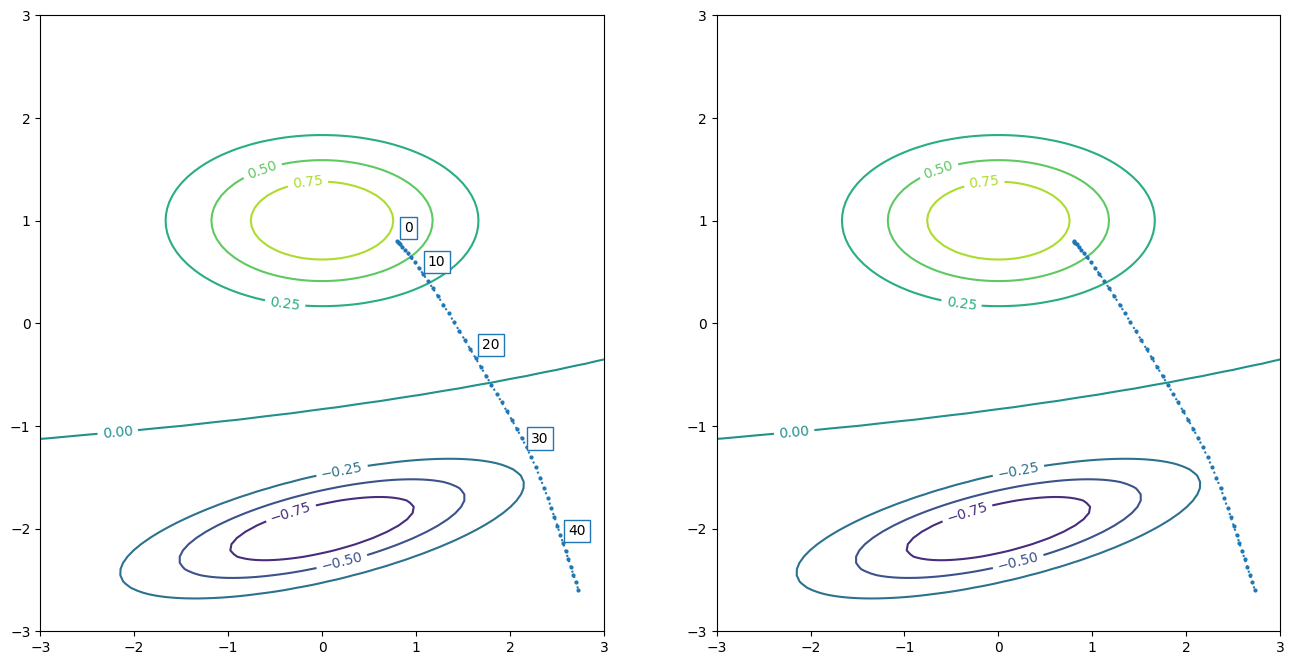

In [265]:
iterate_rec_t = list_trajectory[3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec_t, ax1, label='gradient_descent')
plot_trace(iterate_rec_t, ax2, label='gradient_descent', tags=False)

It diverges.

For `lr=0.10` and `momentum=0.90` (136 iterations):

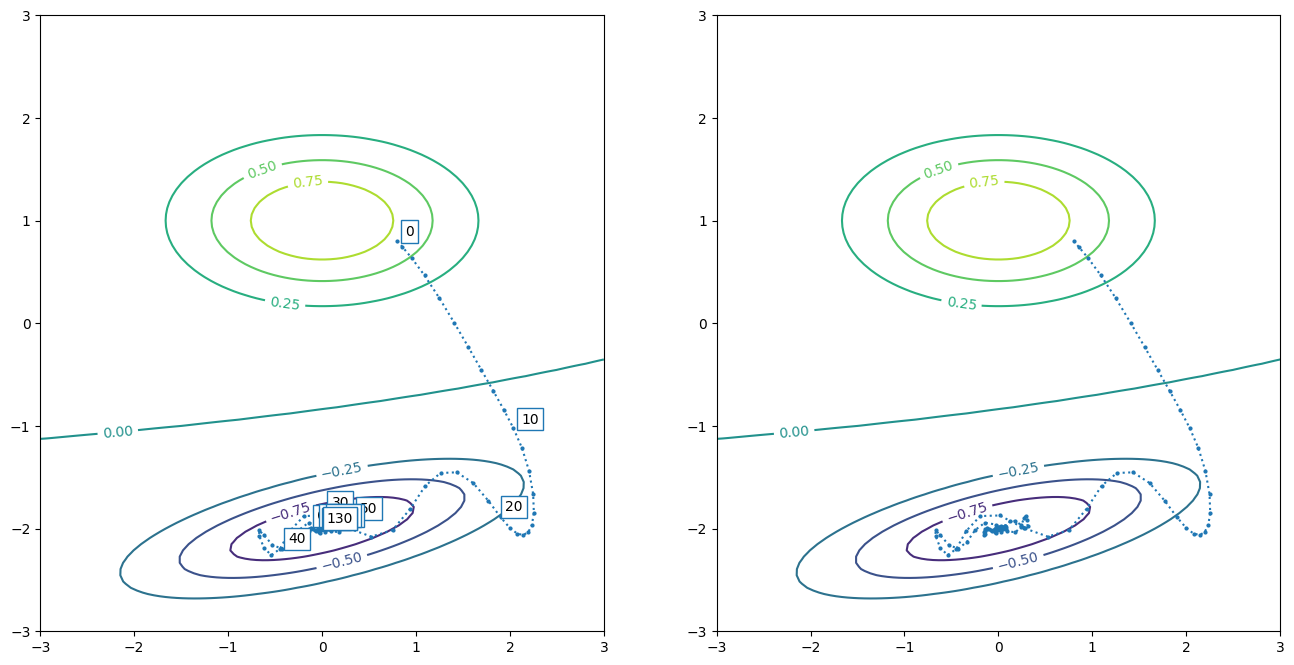

In [266]:
# lr=0.10, momentum=0.90
iterate_rec_t = list_trajectory[10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec_t, ax1, label='gradient_descent')
plot_trace(iterate_rec_t, ax2, label='gradient_descent', tags=False)

It converges ! With `lr=0.1` and `momentum=0.9`, the momentum gradient descent converges in only **136** iterations.

- Add [torch.optim.Adam](http://pytorch.org/docs/main/generated/torch.optim.Adam.html#torch.optim.Adam) and [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) in the minimization loop.

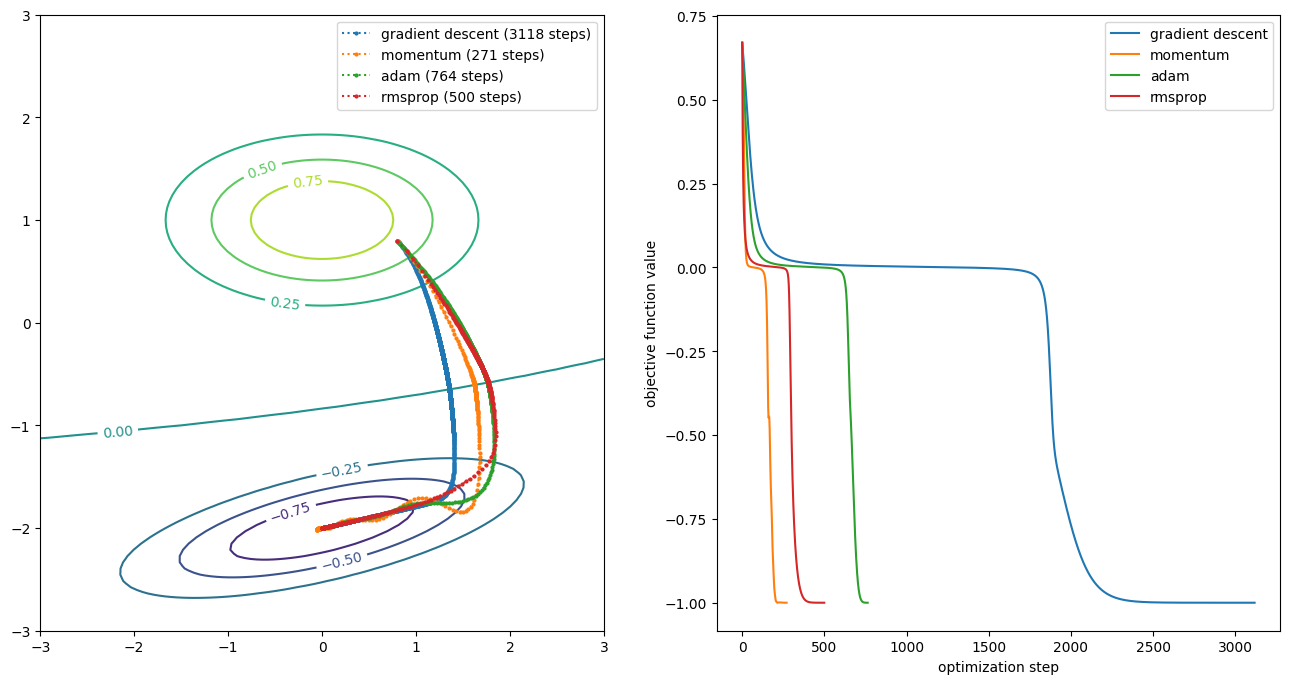

In [267]:
lr = 0.01
init = torch.FloatTensor([0.8, 0.8])

# Gradient Descent
optimizer = GradientDescent([init.clone().requires_grad_()], lr=lr)
iterate_rec_gd = minimize(f, optimizer)

# Momentum
optimizer_mom = MomentumGradientDescent([init.clone().requires_grad_()],
                                    lr=lr)
iterate_rec_mom = minimize(f, optimizer_mom)

# Adam
optimizer_adam = torch.optim.Adam([init.clone().requires_grad_()], lr=lr)
iterate_rec_adam = minimize(f, optimizer_adam)

# RMSprop
optimizer_rmsprop = torch.optim.RMSprop([init.clone().requires_grad_()], lr=lr)
iterate_rec_rmsprop = minimize(f, optimizer_rmsprop)

# Plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the function and the optimization paths
plot_function(f, ax0)
plot_trace(iterate_rec_gd, ax0, label='gradient descent', tags=False)
plot_trace(iterate_rec_mom, ax0, label='momentum', tags=False)
plot_trace(iterate_rec_adam, ax0, label='adam', tags=False)
plot_trace(iterate_rec_rmsprop, ax0, label='rmsprop', tags=False)
ax0.legend()

# Plot the objective function value over optimization steps
ax1.plot([f(x).item() for x in iterate_rec_gd], label='gradient descent')
ax1.plot([f(x).item() for x in iterate_rec_mom], label='momentum')
ax1.plot([f(x).item() for x in iterate_rec_adam], label='adam')
ax1.plot([f(x).item() for x in iterate_rec_rmsprop], label='rmsprop')
ax1.set_xlabel('optimization step')
ax1.set_ylabel('objective function value')
ax1.legend()

What do you observe ? Try changing the momentum and the initialization to compare optimization traces.

With `lr=0.01` and `momentum=0.9`, all optimizers successfully converge. The fastest is `MomentumGradientDescent`, requiring only **271 iterations** to converge, though its trajectory exhibits slight oscillations near the end. Both `Adam` and `RMSprop` show smoother descent trajectories, converging in **764 iterations** and **500 iterations**, respectively. As expected, `GradientDescent`, which lacks momentum, is the slowest, taking **3118 iterations** to reach convergence.

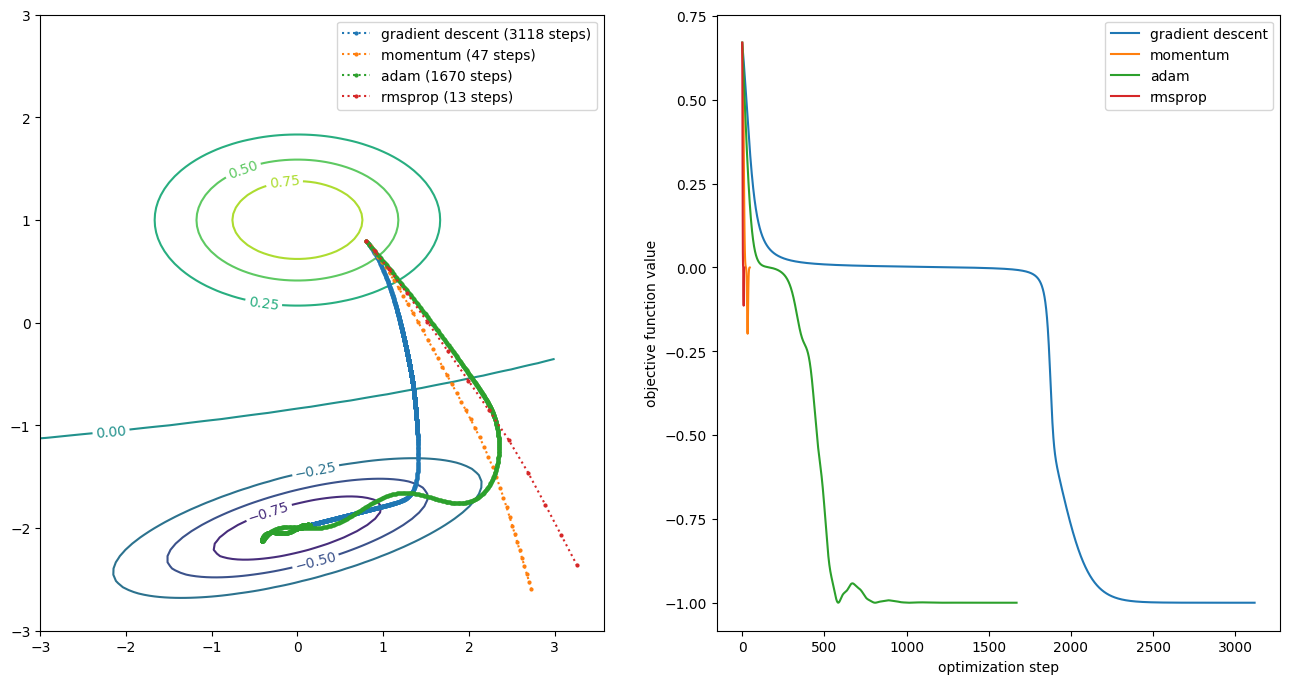

In [268]:
lr = 0.01
init = torch.FloatTensor([0.8, 0.8])
momentum = 0.99

# Gradient Descent
optimizer = GradientDescent([init.clone().requires_grad_()], lr=lr)
iterate_rec_gd = minimize(f, optimizer)

# Momentum
optimizer_mom = MomentumGradientDescent([init.clone().requires_grad_()],
                                    lr=lr, momentum=momentum)
iterate_rec_mom = minimize(f, optimizer_mom)

# Adam
optimizer_adam = torch.optim.Adam([init.clone().requires_grad_()], lr=lr, betas=(momentum, 0.999))
iterate_rec_adam = minimize(f, optimizer_adam)

# RMSprop
optimizer_rmsprop = torch.optim.RMSprop([init.clone().requires_grad_()], lr=lr, momentum=momentum)
iterate_rec_rmsprop = minimize(f, optimizer_rmsprop)

# Plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the function and the optimization paths
plot_function(f, ax0)
plot_trace(iterate_rec_gd, ax0, label='gradient descent', tags=False)
plot_trace(iterate_rec_mom, ax0, label='momentum', tags=False)
plot_trace(iterate_rec_adam, ax0, label='adam', tags=False)
plot_trace(iterate_rec_rmsprop, ax0, label='rmsprop', tags=False)
ax0.legend()

# Plot the objective function value over optimization steps
ax1.plot([f(x).item() for x in iterate_rec_gd], label='gradient descent')
ax1.plot([f(x).item() for x in iterate_rec_mom], label='momentum')
ax1.plot([f(x).item() for x in iterate_rec_adam], label='adam')
ax1.plot([f(x).item() for x in iterate_rec_rmsprop], label='rmsprop')
ax1.set_xlabel('optimization step')
ax1.set_ylabel('objective function value')
ax1.legend()

With a momentum value of **0.99**, both `MomentumGradientDescent` and `RMSprop` fail to converge and diverge instead. However, `Adam` still manages to converge, although at a slower pace compared to lower momentum values.

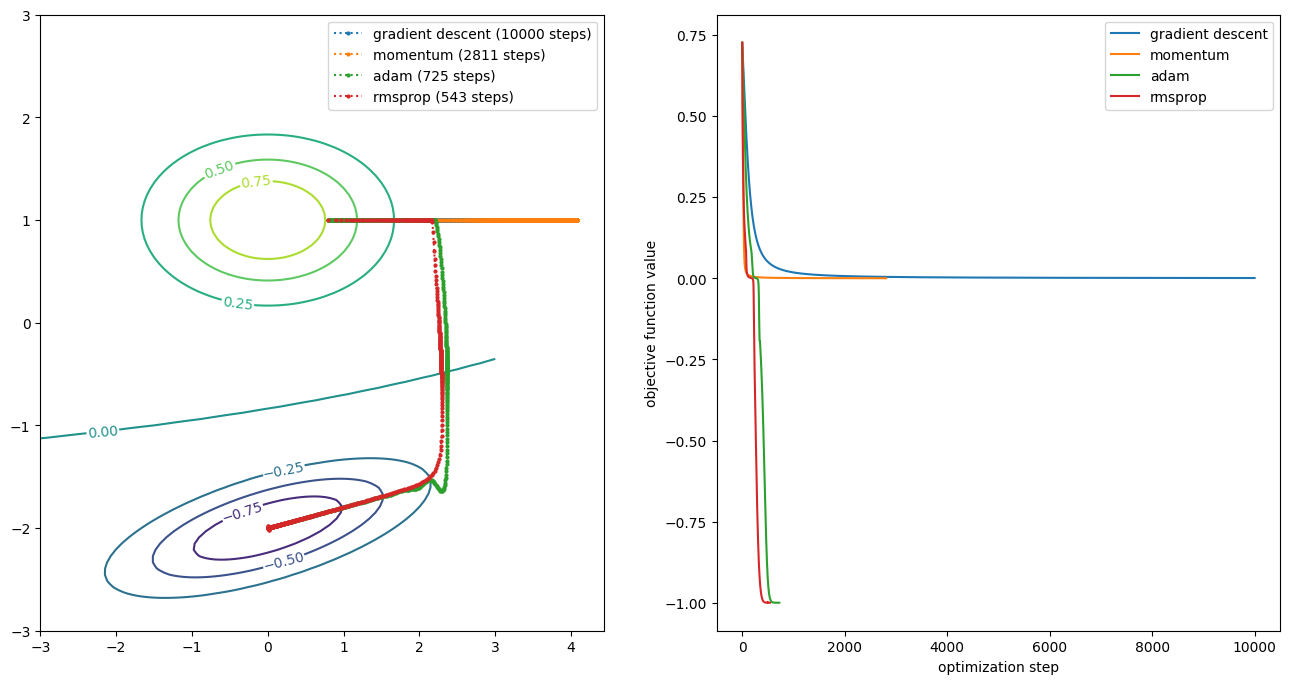

In [269]:
lr = 0.01
init = torch.FloatTensor([0.8, 1])

# Gradient Descent
optimizer = GradientDescent([init.clone().requires_grad_()], lr=lr)
iterate_rec_gd = minimize(f, optimizer)

# Momentum
optimizer_mom = MomentumGradientDescent([init.clone().requires_grad_()],
                                    lr=lr)
iterate_rec_mom = minimize(f, optimizer_mom)

# Adam
optimizer_adam = torch.optim.Adam([init.clone().requires_grad_()], lr=lr)
iterate_rec_adam = minimize(f, optimizer_adam)

# RMSprop
optimizer_rmsprop = torch.optim.RMSprop([init.clone().requires_grad_()], lr=lr)
iterate_rec_rmsprop = minimize(f, optimizer_rmsprop)

# Plotting
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the function and the optimization paths
plot_function(f, ax0)
plot_trace(iterate_rec_gd, ax0, label='gradient descent', tags=False)
plot_trace(iterate_rec_mom, ax0, label='momentum', tags=False)
plot_trace(iterate_rec_adam, ax0, label='adam', tags=False)
plot_trace(iterate_rec_rmsprop, ax0, label='rmsprop', tags=False)
ax0.legend()

# Plot the objective function value over optimization steps
ax1.plot([f(x).item() for x in iterate_rec_gd], label='gradient descent')
ax1.plot([f(x).item() for x in iterate_rec_mom], label='momentum')
ax1.plot([f(x).item() for x in iterate_rec_adam], label='adam')
ax1.plot([f(x).item() for x in iterate_rec_rmsprop], label='rmsprop')
ax1.set_xlabel('optimization step')
ax1.set_ylabel('objective function value')
ax1.legend()

Returning to a momentum value of **0.9** but changing the initial point to **(0.8, 1)**, both `GradientDescent` and `MomentumGradientDescent` fail to converge and diverge. However, `Adam` and `RMSprop` successfully manage to converge despite the new starting point.

---

## PART III - Fashion MNIST classification using PyTorch

In this part, we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using VGG-like architectures (https://arxiv.org/abs/1409.1556). This part is inspired from the MNIST example from PyTorch (https://github.com/pytorch/examples/tree/master/mnist), and introduce tricks to automatically tune and schedule the learning rate for SGD (see this course's slides, https://arxiv.org/abs/1506.01186, and FastAI course for example http://fastai.org).

## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits.

<img src="https://api.wandb.ai/files/kylegtest/fashion-mnist-gan/up6zul3y/media/images/Generator%20Output_1396.png?height=55" alt="fashion_mnist" height="300px">

Let's import a few functions first

In [270]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms

Some system/model hyper parameters

In [271]:
cuda = False
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [272]:
english_labels = [
                  "Trouser",
                  "T-shirt/top",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, **kwargs)

Let's compute the average mean and std of the train images. We will use them for normalizing data later on.

In [273]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [274]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


We now reload the data with a further `Normalize` transform.

In [275]:
train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))]))

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))]))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, **kwargs)


We define a very simple model, suitable for CPU training.

In [276]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), padding=1)
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 20, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout_2d(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.dropout_2d(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, 7 * 7 * 20)  # flatten / reshape
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [277]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.2860]), std=tensor([0.3202]))
           )

We can plot a training image.

In [278]:
model = Model()
img, target = train_data[1]
# n_channel, width, height
print(img.shape)

torch.Size([1, 28, 28])


/var/folders/4q/wlkm41x57nv0n4qhnyv84kjc0000gn/T/ipykernel_18409/599630494.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))


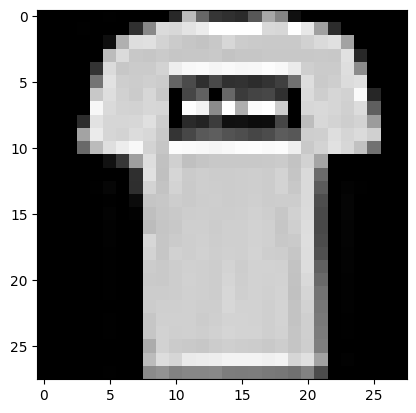

In [279]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

In [280]:
pred = model(img[None, :])
print(target, english_labels[target])
print(pred)

0 Trouser
tensor([[-2.3473, -2.2781, -2.4896, -2.1985, -2.0260, -2.5882, -2.0861, -2.6042,
         -2.3022, -2.2752]], grad_fn=<LogSoftmaxBackward0>)


We define a train loop and a test function.

In [281]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        batch_size = data.shape[0]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(test_loader.dataset)
    return train_loss

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # sum up batch loss
            _, pred = output.data.max(dim=1)
            # get the index of the max log-probability
            correct += torch.sum(pred == target.data.long()).item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = float(correct) / len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f},'
              ' Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * test_accuracy))
    return test_loss, test_accuracy

The `find_lr` function provides a learning rate for SGD or Adam, following heuristics from https://arxiv.org/abs/1506.01186:

In [282]:
import numpy as np

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps

    loader = loop_loader(train_loader)
    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))

        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4

Let's load our model on the GPU if required. We then define an optimizer and a learning rate scheduler. (It takes 4mn to run with CPU Macbook PRO M1).

In [283]:
log_interval = 100
epochs = 12

if cuda:
    model.cuda()

model.reset_parameters()
lr = find_lr(model, train_loader, 1e-4, 1, 100, 30)
model.reset_parameters()

print('Best LR', lr)

Step 0, current LR: 0.000100, loss 2.299926
Step 1, current LR: 0.010099, loss 2.219192
Step 2, current LR: 0.020098, loss 1.767786
Step 3, current LR: 0.030097, loss 1.379189
Step 4, current LR: 0.040096, loss 1.188047
Step 5, current LR: 0.050095, loss 1.124638
Step 6, current LR: 0.060094, loss 1.013035
Step 7, current LR: 0.070093, loss 0.967753
Step 8, current LR: 0.080092, loss 0.964503
Step 9, current LR: 0.090091, loss 0.923252
Step 10, current LR: 0.100090, loss 0.791456
Step 11, current LR: 0.110089, loss 0.755698
Step 12, current LR: 0.120088, loss 0.799460
Step 13, current LR: 0.130087, loss 0.715995
Step 14, current LR: 0.140086, loss 0.782120
Step 15, current LR: 0.150085, loss 0.694013
Step 16, current LR: 0.160084, loss 0.697566
Step 17, current LR: 0.170083, loss 0.699999
Step 18, current LR: 0.180082, loss 0.660103
Step 19, current LR: 0.190081, loss 0.706682
Step 20, current LR: 0.200080, loss 0.678216
Step 21, current LR: 0.210079, loss 0.678918
Step 22, current LR:

Let's train our model.

**NB:** If training a large model is slow on your local computer, try using Google Colab with GPU support.

In [284]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

logs = {'epoch': [], 'train_loss': [], 'test_loss': [],
        'test_accuracy': [], 'lr': []}

In [285]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_loader, epoch)
    test_loss, test_accuracy = test(model, test_loader)
    logs['epoch'].append(epoch)
    logs['train_loss'].append(train_loss)
    logs['test_loss'].append(test_loss)
    logs['test_accuracy'].append(test_accuracy)
    logs['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308210
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.197371
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.556095
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.008964
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.614450
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.533241
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.701263
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.476371
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.871247
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.568604
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.661707
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.383125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.483821
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.368367
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.520261
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.425933
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.394283
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.278775
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.647784


/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3956, Accuracy: 8534/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.329860


/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.616153
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.453938
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.390684
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.353088
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.400933
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.200269
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.427016
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.421872
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.410346
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.417676
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.294987
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.194811
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.517994
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.499687
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.253746
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.712332
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.478536
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.680562

Test set: Average loss: 0.3595, Accuracy: 8602/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.29059

### Exercices

- Define a VGG-like model: add more convolutional and max pooling layers to increase the number of channels progressively while decreasing the dimensions of the feature maps with max pooling.
- Research and briefly explain what dropout is.
- Try to use Adam instead of SGD in conjunction with the `find_lr` heuristic and the cosine learning rate schedule above;
- Try to beat the test accuracy of the model ``class Model(nn.Module):`` above ( $\approx$ 90 %).
- (optional) Try data augmentation (horizontal flips, random crops, cutout...);
- (optional) Try to use batch-normalization;
- (optional) Implement the [mixup stochastic label interpolation](https://arxiv.org/abs/1710.09412);
- (optional) Implement skip-connections.

See how you compare to other approaches:
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/zalando-research/fashionmnist

**NB:** If training a large model is slow on your local computer, try using Google Colab with GPU support.

This class implements a basic VGG-like convolutional block with multiple convolutions and optional max pooling. The model consists of multiple VGGCell blocks followed by fully connected layers for classification. Dropout is used for regularization.

**Dropout** Dropout is a regularization technique that helps prevent overfitting in neural networks. The idea is to randomly set a fraction of input units (neurons) to zero during training. This forces the model to not rely too heavily on any individual neuron, thereby promoting more generalization.

**How Does Dropout Work?**

1. **During Training**: A fraction of neurons are randomly "dropped out" (set to zero) with a probability `p`, which is the dropout rate.
2. **During Testing**: All neurons are active, but their output is scaled by the factor of `(1 - p)` to compensate for the dropout during training.

**Dropout in Our Model**

In the model, we have the following line:
```python
nn.Dropout(0.5)  # Dropout with a 50% probability
```
This means that during training, 50% of the neurons in this layer will be randomly set to zero. This helps prevent the model from overfitting by forcing the network to learn redundant representations.

Advantages of Dropout:
1. Prevents Overfitting: By randomly dropping neurons, dropout forces the model to learn more robust features and not over-rely on specific neurons.
2. Improves Generalization: Dropout helps the network generalize better to unseen data, as it cannot memorize the training data.
3. Increased Robustness: By training with different "sub-networks" each time, dropout makes the model more adaptable to variations in the input data.


#### VGGCell Class Definition and Model Class Definition

The `VGGCell` class defines a building block of our model that consists of multiple convolutional layers followed by batch normalization and ReLU activation functions. Each `VGGCell` includes a sequence of convolutions with batch normalization and ReLU activations to learn feature representations from input data. We also apply max pooling to reduce spatial dimensions and down-sample the feature maps. This class is designed to be reusable, and the number of convolutional layers (`depth`) can be adjusted based on the desired model complexity. The `reset_parameters` method allows us to reinitialize the weights of the layers if needed.

We define the complete neural network model using the `VGGCell` class. The model consists of four `VGGCell` blocks (`vgg1` to `vgg4`) where the number of filters increases with each block. After passing through these convolutional layers, we flatten the feature maps and apply fully connected layers for classification. The first fully connected layer has 256 units and uses ReLU activation, while the second layer outputs the final prediction with 10 units for the 10 classes in the FashionMNIST dataset. Dropout is applied to the fully connected layers to prevent overfitting. The `reset_parameters` method ensures that all layers, including the fully connected layers, are reinitialized if needed.


In [286]:
class VGGCell(nn.Module):
    def __init__(self, in_channel, out_channel, depth, max_pooling=True):
        super(VGGCell, self).__init__()
        layers = []
        for i in range(depth):
            if i == 0:
                layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))
            else:
                layers.append(nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
        self.convs = nn.Sequential(*layers)
        self.max_pooling = max_pooling

    def forward(self, x):
        x = self.convs(x)
        if self.max_pooling:
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        return x

    def reset_parameters(self):
        for layer in self.convs:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.vgg1 = VGGCell(1, 32, 2, max_pooling=True)
        self.vgg2 = VGGCell(32, 64, 2, max_pooling=True)
        self.vgg3 = VGGCell(64, 128, 3, max_pooling=True)
        self.vgg4 = VGGCell(128, 256, 3, max_pooling=True)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.vgg1(x)
        x = self.vgg2(x)
        x = self.vgg3(x)
        x = self.vgg4(x)
        x = self.fc(x)
        return x

    def reset_parameters(self):
        self.vgg1.reset_parameters()
        self.vgg2.reset_parameters()
        self.vgg3.reset_parameters()
        self.vgg4.reset_parameters()
        for layer in self.fc:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()



#### MixUp Implementation

MixUp is a data augmentation technique used to improve model generalization. In this cell, we implement the MixUp functionality with two key components: `mixup_data` and `mixup_criterion`. The `mixup_data` function combines pairs of images and their corresponding labels using a random lambda value sampled from a beta distribution. This creates new, mixed data points and their labels. The `mixup_criterion` calculates the loss by weighting the contributions from the mixed labels based on the lambda value. MixUp is known to improve model robustness by creating virtual training examples that are linear combinations of real data points.


In [287]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


#### Data Preprocessing

Here, we define the data preprocessing steps for both the training and testing datasets. For training, we apply several augmentation techniques such as random horizontal flipping, random cropping with padding, and random erasing. These augmentations increase the variability in the data and help the model generalize better. Additionally, we normalize the images to a range of [-1, 1] using the mean and standard deviation values of 0.5. For the test set, we only apply normalization without augmentations to ensure the evaluation is done on original images. The datasets are then loaded into DataLoader objects, which handle batching and shuffling of the data for training and testing.


In [288]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.5)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device and Model Initialization

We check if a GPU is available and select it for model training if possible. If a GPU is not available, the model will be trained on the CPU. We then initialize the `Model` class, which contains the complete neural network architecture. The loss function used is `CrossEntropyLoss`, which is commonly used for classification tasks. The optimizer is Adam, a popular choice for training deep learning models due to its efficiency and adaptive learning rate. We also set up a learning rate scheduler, `CosineAnnealingLR`, which adjusts the learning rate during training to improve convergence and reduce overfitting.


In [289]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Using device: cpu


#### Training Function

This function is responsible for training the model for one epoch. During each epoch, we use the MixUp data augmentation technique to create mixed samples and their corresponding labels. The `mixup_data` function is called to apply MixUp to the current batch of images and labels. The model then makes predictions on the mixed data, and the loss is calculated using the `mixup_criterion`. The loss is backpropagated, and the optimizer updates the model's parameters. The running loss is accumulated for the entire epoch and averaged to give the final loss for the epoch.


In [290]:
def train(model, device, train_loader, optimizer, criterion, alpha=1.0):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        mixed_data, target_a, target_b, lam = mixup_data(data, target, alpha)
        optimizer.zero_grad()
        output = model(mixed_data)
        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

#### Testing Function

The `test` function evaluates the trained model on the test dataset. During testing, we disable gradient computation using `torch.no_grad()` to save memory and speed up the process. The model makes predictions on the test data, and the predicted class labels are compared to the true labels to compute the number of correct predictions. The accuracy is then calculated as the percentage of correct predictions over the total number of test samples. This function is used after each epoch to monitor the model's performance on unseen data.


In [291]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

#### Training Loop

The training loop runs for a specified number of epochs. In each epoch, the `train` function is called to perform training, and the `test` function is called to evaluate the model on the test set. After each epoch, the learning rate scheduler (`CosineAnnealingLR`) is updated to adjust the learning rate. This helps the model converge faster and avoid overshooting the optimal solution. The training loss and test accuracy are printed after each epoch to monitor the model's progress and performance. By the end of the loop, the model will have been trained for the desired number of epochs.


In [292]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, alpha=0.4)
    test_acc = test(model, device, test_loader)
    scheduler.step()
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

KeyboardInterrupt: 

## PART IV

Summarize what you have learned from this project and the course in general. Describe the skills you have gained and what you are now able to accomplish with PyTorch.